In [1]:
import os
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


### En este script hacemos clustering y reducción de dimensionalidad de  datos del estornudo

In [3]:
os.chdir('/Users/benx/Documents/PythonCodes/DropletsData/ClusterRun')

# Cargamos el archivo de datos
droplets_df = pd.read_csv('k21_clean_data.csv', sep=',')

# Seleccionamos las variables de interés para el clustering
columnas_interes = ['PosX', 'PosY', 'PosZ', 'Diam_micro']
datos = droplets_df[columnas_interes].values

# Función para calcular las distancias cuadradas en el espacio del kernel
def calcular_distancias_kernel(K, etiquetas, clusters, n_clusters):
    distancias = np.zeros((K.shape[0], n_clusters))
    
    for j in range(n_clusters):
        cluster_mask = etiquetas == j
        n_puntos_cluster = np.sum(cluster_mask)
        
        if n_puntos_cluster > 0:
            # Calcular la distancia en el espacio del kernel
            K_cluster = K[cluster_mask][:, cluster_mask]
            distancias[:, j] = np.diag(K) - 2 * np.mean(K[:, cluster_mask], axis=1) + np.mean(K_cluster)
        else:
            distancias[:, j] = np.inf
    
    return distancias

# Algoritmo Kernel K-Means
def kernel_k_means(datos, n_clusters, kernel='rbf', max_iter=100, tol=1e-6):
    # Calcula la matriz de kernel
    K = pairwise_kernels(datos, metric=kernel)

    # Inicialización aleatoria de etiquetas
    n_puntos = datos.shape[0]
    etiquetas = np.random.randint(0, n_clusters, size=n_puntos)

    for iteracion in range(max_iter):
        # Calcula las distancias en el espacio del kernel
        distancias = calcular_distancias_kernel(K, etiquetas, range(n_clusters), n_clusters)

        # Asigna cada punto al cluster más cercano
        nuevas_etiquetas = np.argmin(distancias, axis=1)

        # Verifica convergencia
        if np.all(etiquetas == nuevas_etiquetas):
            print(f"Convergencia alcanzada en la iteración {iteracion}.")
            break

        etiquetas = nuevas_etiquetas

    return etiquetas, K

# Escalar los datos
escalador = StandardScaler()
datos_escalados = escalador.fit_transform(datos)

Convergencia alcanzada en la iteración 9.
Convergencia alcanzada en la iteración 7.
Convergencia alcanzada en la iteración 22.
Convergencia alcanzada en la iteración 12.
Convergencia alcanzada en la iteración 14.


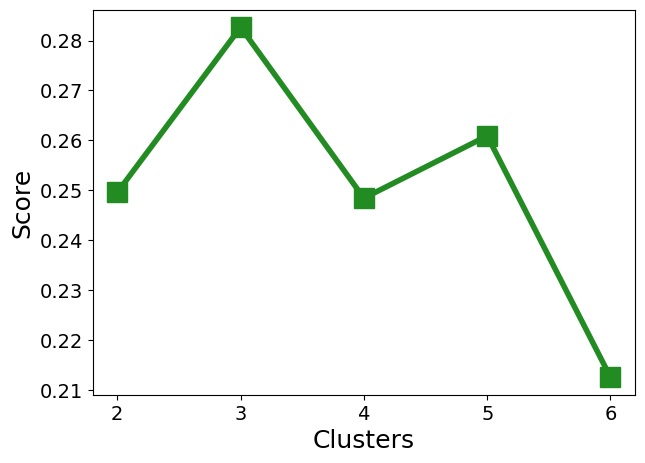

In [4]:

# Probar diferentes números de clusters
rangos_clusters = range(2, 7)  # De 2 a 7 clusters
silhouette_scores = []

for n_clusters in rangos_clusters:
    etiquetas, _ = kernel_k_means(datos_escalados, n_clusters=n_clusters, kernel='rbf')
    score = silhouette_score(datos_escalados, etiquetas)
    silhouette_scores.append(score)

# Visualizar el Silhouette Score
plt.figure(figsize=(7, 5))
plt.plot(rangos_clusters, silhouette_scores, marker='s', markersize=15, linestyle='-', color='forestgreen', lw=4)

#plt.title('Silhouette Score para diferentes números de clusters')
plt.xlabel('Clusters',fontsize=18)
plt.ylabel('Score', fontsize=18)
custom_xticks= [2,3,4,5,6]
plt.xticks(custom_xticks, fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('k21_score.png')
plt.show()


Convergencia alcanzada en la iteración 13.


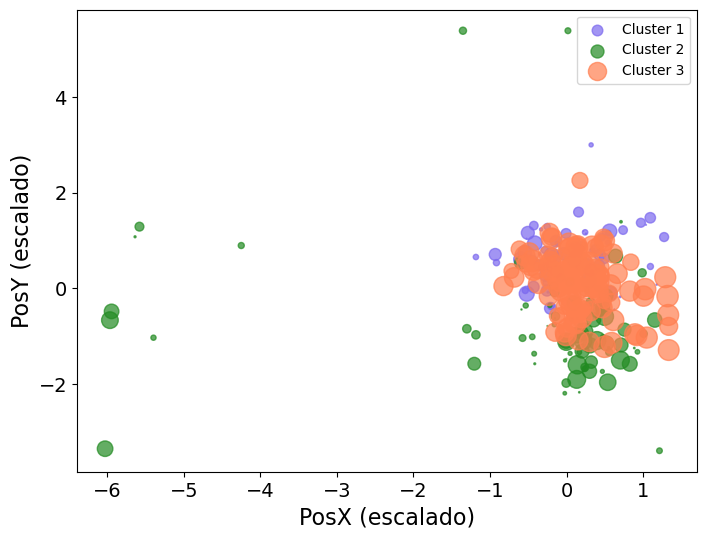

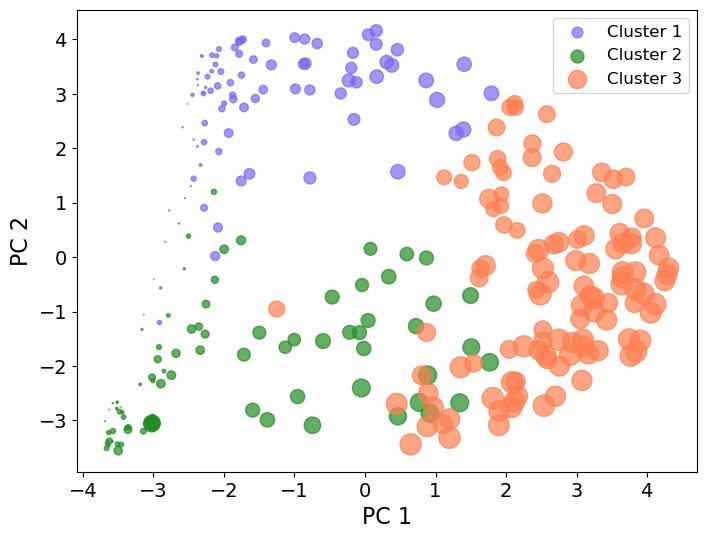

In [15]:
# Número de clusters
n_clusters = 3

# Aplicamos Kernel K-Means
etiquetas, K = kernel_k_means(datos_escalados, n_clusters=n_clusters, kernel='rbf')

# Visualización en el espacio original
plt.figure(figsize=(8, 6))
colores = ['mediumslateblue', 'forestgreen', 'coral', 'red','cyan', 'k']
#colores = cm.Dark2(np.linspace(0, 1, n_clusters))  # Paleta 'tab10', puedes cambiarla por 'viridis', 'plasma', etc.
tamaños = droplets_df['Diam_micro']  # Tamaños de los puntos según 'Diam_micro'

for cluster in range(n_clusters):
    cluster_mask = etiquetas == cluster
    plt.scatter(
        datos_escalados[cluster_mask, 0], 
        datos_escalados[cluster_mask, 1], 
        s=0.0003*tamaños[cluster_mask],  # Tamaño de los puntos
        label=f'Cluster {cluster + 1}', 
        alpha=0.7, 
        color=colores[cluster]
    )

#plt.title('Kernel K-Means')
plt.xlabel('PosX (escalado)', fontsize=16)
plt.ylabel('PosY (escalado)', fontsize=16)
plt.xticks(fontsize=14)

plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.legend()
plt.savefig('k21kmeans.png')
plt.show()

# Reducción de dimensionalidad del espacio del kernel con PCA
pca = PCA(n_components=3)
K_reducido = pca.fit_transform(K)

# Visualización en el espacio transformado
plt.figure(figsize=(8, 6))
for cluster in range(n_clusters):
    cluster_mask = etiquetas == cluster
    plt.scatter(
        K_reducido[cluster_mask, 0], 
        K_reducido[cluster_mask, 1], 
        s=0.0003*tamaños[cluster_mask],  # Tamaño de los puntos
        label=f'Cluster {cluster + 1}', 
        alpha=0.7, 
        color=colores[cluster]
    )

#plt.title('Espacio Transformado (Kernel PCA)')
plt.xlabel('PC 1', fontsize=16)
plt.ylabel('PC 2', fontsize=16)
plt.xticks(fontsize=14)

plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.savefig('k21PCA.png')

plt.show()


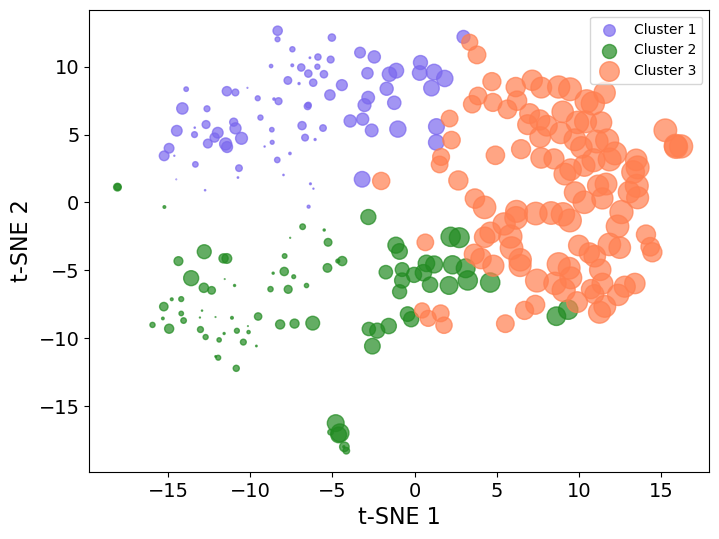

In [16]:

# Aplicamos t-SNE al espacio original de datos
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
datos_tsne = tsne.fit_transform(datos_escalados)

# Visualización en el espacio t-SNE
plt.figure(figsize=(8, 6))
for cluster in range(n_clusters):
    cluster_mask = etiquetas == cluster
    plt.scatter(
        datos_tsne[cluster_mask, 0], 
        datos_tsne[cluster_mask, 1], 
        s=0.00035*tamaños[cluster_mask],  # Tamaño de los puntos según 'Diam_micro'
        label=f'Cluster {cluster + 1}', 
        alpha=0.7, 
        color=colores[cluster]
    )

#plt.title('Visualización con t-SNE')

plt.xlabel('t-SNE 1', fontsize=16)
plt.ylabel('t-SNE 2', fontsize=16)
plt.xticks(fontsize=14)

plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.legend()
plt.savefig('k21tSNE.png')

plt.show()


In [17]:


# Aplicamos PCA
pca = PCA()
pca.fit(datos_escalados)

# Cargas de las componentes principales
cargas = pd.DataFrame(pca.components_, columns=columnas_interes, index=[f'PC{i+1}' for i in range(len(columnas_interes))])

# Varianza explicada por cada componente
varianza_explicada = pca.explained_variance_ratio_

print("Cargas de las componentes principales:")
print(cargas)

print("\nVarianza explicada por cada componente principal:")
for i, var in enumerate(varianza_explicada):
    print(f"PC{i+1}: {var:.2%}")



Cargas de las componentes principales:
         PosX      PosY      PosZ  Diam_micro
PC1  0.045412 -0.479697 -0.738912   -0.470996
PC2 -0.680032  0.402422  0.083934   -0.607099
PC3 -0.632559 -0.684368  0.223253    0.285775
PC4 -0.367919  0.373615 -0.630176    0.572648

Varianza explicada por cada componente principal:
PC1: 29.92%
PC2: 28.28%
PC3: 23.42%
PC4: 18.38%


In [18]:
# Calculamos correlaciones entre variables originales y las dimensiones t-SNE
tsne_df = pd.DataFrame(datos_tsne, columns=['t-SNE1', 't-SNE2'])
correlaciones = droplets_df[columnas_interes].join(tsne_df).corr()

print("Correlaciones entre las variables originales y las dimensiones t-SNE:")
print(correlaciones[['t-SNE1', 't-SNE2']])


Correlaciones entre las variables originales y las dimensiones t-SNE:
              t-SNE1    t-SNE2
PosX        0.094698  0.237725
PosY       -0.042712  0.569676
PosZ        0.280586  0.673592
Diam_micro  0.922484  0.020865
t-SNE1      1.000000  0.072696
t-SNE2      0.072696  1.000000
